In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import os
import time
import pandas as pd
from PIL import Image
# import autokeras as ak
import h5py
import gc


# from google.colab import drive
# drive.mount('/content/drive')

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, TimeDistributed, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint


import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

from tensorflow.keras.utils import to_categorical, plot_model
from keras.preprocessing.image import load_img
from keras.models import Sequential, save_model

from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D


In [ ]:
# DATASET PATHS

# TRAIN_DIR = "D:\Zeina\Documents\GUC\8th Semester\Datasets\Celeb-DF\extract_frames\Train"
# TEST_DIR = 'D:\Zeina\Documents\GUC\8th Semester\Datasets\Celeb-DF\extract_frames\Test'
# VAL_DIR = 'D:\Zeina\Documents\GUC\8th Semester\Datasets\Celeb-DF\extract_frames\Validation'


# TRAIN_DIR = "/content/drive/MyDrive/Celeb-DF/Kaggle_Train"
# VAL_DIR = "/content/drive/MyDrive/Celeb-DF/Validation"

DATA_DIR = '/kaggle/input/deepfake-detection-challenge'
TRAIN_FOLDER = 'train_sample_videos'
TEST_FOLDER = 'test_videos'

face_detector=cv2.CascadeClassifier('/kaggle/input/haar-cascades-for-face-detection/haarcascade_frontalface_default.xml')


print(f"Train Samples: {len(os.listdir(os.path.join(DATA_DIR, TRAIN_FOLDER)))}")
print(f"Test Samples: {len(os.listdir(os.path.join(DATA_DIR, TEST_FOLDER)))}")

img_size = 64
seq_length = 50
step = 10
batch_size = 32

In [12]:
# import cv2
# face_detector=cv2.CascadeClassifier('/kaggle/input/haar-cascades-for-face-detection/haarcascade_frontalface_default.xml')

# import matplotlib.pyplot as plt

# img_path = '/kaggle/input/test-img/IMG_0953.JPG'

# img = cv2.imread(img_path)
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# faces = face_detector.detectMultiScale(gray, 1.3, 5)

# print(len(faces))

# for (x, y, w, h) in faces: 
#     cv2.rectangle(img, (x, y), (x+w, y+h),  
#                   (0, 0, 255), 2) 
      
#     faces = img[y:y + h, x:x + w] 
#     cv2.imshow("face",faces) 
#     cv2.imwrite('face.jpg', faces) 
  
# cv2.imshow('img', img) 
# cv2.waitKey()

In [13]:
train_list = list(os.listdir(os.path.join(DATA_DIR, TRAIN_FOLDER)))
test_list = list(os.listdir(os.path.join(DATA_DIR, TEST_FOLDER)))


In [14]:
train_files, test_files = train_test_split(train_list, test_size=0.2, random_state=42)    # test size = 20%
train_files, val_files = train_test_split(train_files, test_size=0.1, random_state=42)    # test size = 20%

print(len(train_files))
print(len(test_files))
print(len(val_files))

288
81
32


In [17]:
def detect_face(img):
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_detector.detectMultiScale(img, 1.3, 5)
    
    #if at least one face detected
    if(len(faces) > 0):
        for (x,y,w,h) in faces:
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
            face = img[y:y + h, x:x + w] #crop frame to face
            return face
    else:
        return img #if no face detected use frame as is
#         cv2.imshow("face",faces) 

In [18]:
def load_frames_from_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        face = detect_face(frame)
        frame = cv2.resize(frame, (img_size, img_size))
        frame = frame.astype('float32') / 255.0
        frames.append(frame)
    cap.release()

    # Pad or slice frames to have a consistent sequence length
    if len(frames) < seq_length:
        frames += [np.zeros((img_size, img_size, 3))] * (seq_length - len(frames))
    frames = frames[:seq_length]

    return np.array(frames)

In [19]:
def load_metadata(metadata_file):
    metadata = pd.read_json(metadata_file)
    metadata = metadata.T    
    video_labels = {}
    for index, row in metadata.iterrows():
        video_labels[f"{index}"] = row['label']
    return video_labels

In [20]:
metadata_file = "/kaggle/input/deepfake-detection-challenge/train_sample_videos/metadata.json"
labels = load_metadata(metadata_file)

## Exploratory Data Analysis

In [21]:
real_count = len([label for label in labels.values() if label == "REAL"])
fake_count = len([label for label in labels.values() if label == "FAKE"])

print(f"Real videos: {real_count}")
print(f"Fake videos: {fake_count}")

Real videos: 77
Fake videos: 323


In [22]:
## get list of real and fake files
labeled_files = {label: [k for k, v in labels.items() if v == label] for label in set(labels.values())}

real_files = labeled_files['REAL']
fake_files = labeled_files['FAKE']

print(f"Real videos: {len(real_files)}")
print(f"Fake videos: {len(fake_files)}")

Real videos: 77
Fake videos: 323


In [23]:
##### Splitting the dataset into train, validation, and test sets

## REAL 
real_train, real_test = train_test_split(real_files, test_size=0.2, random_state=42)    # test size = 20%
real_train, real_val = train_test_split(real_train, test_size=0.1, random_state=42)     # validation size = 10% of train (80%) = 8%

## FAKE
fake_train, fake_test = train_test_split(fake_files, test_size=0.2, random_state=42)   
fake_train, fake_val = train_test_split(fake_train, test_size=0.1, random_state=42)

print("TESTING SET (20%)")
print(f"Real Test Files: {len(real_test)}")
print(f"Fake Test Files: {len(fake_test)}")

print("---------------------------------------------")

print("VALIDATION SET (8%)")
print(f"Real Validation Files: {len(real_val)}")
print(f"Fake Validation Files: {len(fake_val)}")

print("---------------------------------------------")

print("TRAINING SET (72%)")
print(f"Real Train Files: {len(real_train)}")
print(f"Fake Train Files: {len(fake_train)}")

print("---------------------------------------------")


train_files = real_train + fake_train
val_files = real_val + fake_val
test_files = real_test + fake_test

# shuffle training data
np.random.shuffle(train_files)

print(f"Total Train Files: {len(train_files)}")
print(f"Total Test Files: {len(test_files)}")
print(f"Total Validation: {len(val_files)}")



TESTING SET (20%)
Real Test Files: 16
Fake Test Files: 65
---------------------------------------------
VALIDATION SET (8%)
Real Validation Files: 7
Fake Validation Files: 26
---------------------------------------------
TRAINING SET (72%)
Real Train Files: 54
Fake Train Files: 232
---------------------------------------------
Total Train Files: 286
Total Test Files: 81
Total Validation: 33


In [24]:
def create_dataset(video_dir, files, metadata_file, is_train):
    video_labels = load_metadata(metadata_file)
    frames = []
    labels = []
    for video_file in tqdm(files):
        if video_file.endswith('mp4'):
            video_path = os.path.join(video_dir, video_file)
            vid_frames = load_frames_from_video(video_path)
            label = video_labels[f"{video_file}"]
            print(video_file, label)
            frames.append(vid_frames)
            labels.append(0 if label == 'REAL' else 1)
            
#             dataset.append((frames, label))
            
    dataset = tf.data.Dataset.from_tensor_slices((frames, labels))
    if is_train:
        dataset = dataset.shuffle(buffer_size=100)
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [25]:
video_dir = os.path.join(DATA_DIR, TRAIN_FOLDER)
metadata_file = "/kaggle/input/deepfake-detection-challenge/train_sample_videos/metadata.json"

val_data = create_dataset(video_dir, val_files, metadata_file, False)


atvmxvwyns.mp4 REAL
ckkuyewywx.mp4 REAL
drcyabprvt.mp4 REAL
dkuayagnmc.mp4 REAL
cpjxareypw.mp4 REAL
bilnggbxgu.mp4 REAL
bddjdhzfze.mp4 REAL
axwgcsyphv.mp4 FAKE
cwsbspfzck.mp4 FAKE
ebebgmtlcu.mp4 FAKE
caqbrkogkb.mp4 FAKE
bweezhfpzp.mp4 FAKE
bbhtdfuqxq.mp4 FAKE
dvakowbgbt.mp4 FAKE
bmbbkwmxqj.mp4 FAKE
dhkwmjxwrn.mp4 FAKE
dcuiiorugd.mp4 FAKE
cyclgfjdrv.mp4 FAKE
benmsfzfaz.mp4 FAKE
azsmewqghg.mp4 FAKE
dofusvhnib.mp4 FAKE
cdyakrxkia.mp4 FAKE
bntlodcfeg.mp4 FAKE
bmhvktyiwp.mp4 FAKE
cmxcfkrjiv.mp4 FAKE
ehfiekigla.mp4 FAKE
agdkmztvby.mp4 FAKE
dakqwktlbi.mp4 FAKE
elvvackpjh.mp4 FAKE
cxttmymlbn.mp4 FAKE
dtocdfbwca.mp4 FAKE
brvqtabyxj.mp4 FAKE
eahlqmfvtj.mp4 FAKE



In [ ]:
train_data = create_dataset(video_dir, train_files, metadata_file, True)


In [ ]:
test_data = create_dataset(video_dir, test_files, metadata_file, False)


In [ ]:
batch_size = 32

# Calculate the number of steps per epoch for training and validation
train_steps_per_epoch = np.ceil(len(train_files) / batch_size).astype(int)
val_steps_per_epoch = np.ceil(len(val_files) / batch_size).astype(int)
test_steps_per_epoch = np.ceil(len(test_files) / batch_size).astype(int)

# Calculate the number of samples in each set
num_train_samples = len(train_files)
num_val_samples = len(val_files)
num_test_samples = len(test_files)

# Print the number of samples in each set
print("Number of training samples:", num_train_samples)
print("Number of validation samples:", num_val_samples)
print("Number of test samples:", num_test_samples)

print("train_steps_per_epoch:", train_steps_per_epoch)
print("val_steps_per_epoch", val_steps_per_epoch)
print("test_steps_per_epoch", test_steps_per_epoch)

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM

#======================================================================================
#                               CNN COMPONENT
#======================================================================================

cnn_model = tf.keras.Sequential([
    Conv2D(8, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),  #8 filters, each 3x3, input images size 64x64x3(rgb channels), relu activation to output
    MaxPooling2D((2, 2)),   #max pooling with pool size 2x2 (selects max value in every 2x2 filter -> reduces spatial dimension by factor of 2
    Conv2D(16, (3, 3), activation='relu'),  #16 filters, each 3x3, relu activation to output
    MaxPooling2D((2, 2)),      #max pooling with pool size 2x2 (selects max value in every 2x2 filter -> reduces spatial dimension by factor of 2
    Conv2D(32, (3, 3), activation='relu'),  #32 filters, each 3x3, relu activation to output
    MaxPooling2D((2, 2)),       #max pooling with pool size 2x2 (selects max value in every 2x2 filter -> reduces spatial dimension by factor of 2
    Conv2D(64, (3, 3), activation='relu'), #64 filters, each 3x3, relu activation to output
    MaxPooling2D((2, 2)),   #max pooling with pool size 2x2 (selects max value in every 2x2 filter -> reduces spatial dimension by factor of 2
    Flatten()       #flattens output into a 1D vector
])

In [ ]:
from tensorflow.keras.layers import Dense, TimeDistributed, Dropout

#======================================================================================
#                               FULL FER MODEL
#======================================================================================

model = tf.keras.Sequential([
    TimeDistributed(cnn_model, input_shape=(seq_length, img_size, img_size, 3)),        #CNN MODEL
    LSTM(32),      #LSTM

    #===================================================
    #              FULLY CONNECTED LAYER
    #===================================================

    #utilizes the extracted features and temporal information to learn complex relationships and transform the features into higher-level representations.

    Dense(16, activation='relu'),       #fixed-length representation input from LSTM and applies ReLU activation function -> introduces non-linearity -> learn complex relationships between features.
    Dropout(0.2),       #prevent overfitting -> 20% of output set to 0

    #===================================================
    #               OUTPUT LAYER
    #===================================================

    #binary classification using sigmoid activation -> 0 or 1 -> probability of belonging to class
    #if value > 0.5 -> fake, if < 0.5 -> real

    Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),     #adam optimizer with learning rate 0.0001
              loss='binary_crossentropy',       #loss function
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.utils import to_categorical, plot_model

model.summary()

# Plot the model architectures
plot_model(model, show_shapes=True, to_file="model.png")


In [ ]:
history = model.fit(train_data,
                    steps_per_epoch=train_steps_per_epoch,
                    epochs=20,
                    batch_size = batch_size,
                    validation_data=val_data,
                    validation_steps=val_steps_per_epoch)

In [ ]:


# Export the best model architecture
# best_model = model.export_model()

# Save the model
save_model(model, '/kaggle/working/best_model.h5')

# Print the model summary
model.summary()

# Plot the model architecture
plot_model(model, show_shapes=True, to_file="best_model.png")

In [ ]:
best_model = model

# Compile the best model
best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
best_model.fit(train_data, epochs=20, validation_data = val_data)

# Evaluate the model on the test data
test_loss, test_accuracy = best_model.evaluate(test_data)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

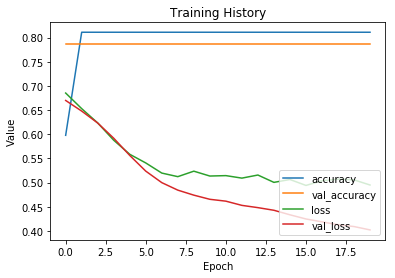

In [27]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc='lower right')
plt.title('Training History')
plt.show()

In [ ]:
def test_dataset(video_dir):
#     video_labels = load_metadata(metadata_file)
    dataset = []
    for video_file in tqdm(os.listdir(video_dir)):
        if video_file.endswith('mp4'):
            video_path = os.path.join(video_dir, video_file)
            frames = load_frames_from_video(video_path)
#             label = video_labels[f"{video_file}"]
#             print(video_file, label)
            dataset.append((frames))
    return dataset

In [ ]:
test_data = test_dataset(os.path.join(DATA_DIR, TEST_FOLDER))

In [ ]:
print(train_data)

train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
train_dataset = train_dataset.shuffle(buffer_size=1000)
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Splitting the dataset into train, validation, and test sets
from sklearn.model_selection import train_test_split

real_files = os.listdir(os.path.join(DATA_DIR, 'Celeb-real'))
fake_files = os.listdir(os.path.join(DATA_DIR, 'Celeb-synthesis'))

real_train, real_test = train_test_split(real_files, test_size=0.2, random_state=42)    # test size = 20%
real_train, real_val = train_test_split(real_train, test_size=0.1, random_state=42)     # validation size = 10% of train (80%) = 8%

fake_train, fake_test = train_test_split(fake_files, test_size=0.2, random_state=42)   
fake_train, fake_val = train_test_split(fake_train, test_size=0.1, random_state=42)

train_files = real_train + fake_train
val_files = real_val + fake_val
test_files = real_test + fake_test

# shuffle training data
np.random.shuffle(train_files)

In [ ]:
def setup_dataset(root_path, batch_size, is_training):
    frame_paths, labels = [], []
    for category in ("Celeb-real", "Celeb-synthesis"):
        folder_path = os.path.join(root_path, category)
        if(category == "Celeb-real"):
          files = real_files
        else:
          files = fake_files
        # videos = os.listdir(folder_path)
        for video_name in tqdm(files):
            video_path = os.path.join(folder_path, video_name)
            print("video_path", video_path)
            frames = load_frames_from_video(video_path)
            frame_paths.append(frames)
            labels.append(0 if category == "Celeb-real" else 1)

    dataset = tf.data.Dataset.from_tensor_slices((frame_paths, labels))
    if is_training:
        dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
import sys
sys.path.append('../')
from pycore.tikzeng import *

# defined your arch
arch = [
    to_head( '..' ),
    to_cor(),
    to_begin(),
    to_Conv("conv1", 512, 64, offset="(0,0,0)", to="(0,0,0)", height=64, depth=64, width=2 ),
    to_Pool("pool1", offset="(0,0,0)", to="(conv1-east)"),
    to_Conv("conv2", 128, 64, offset="(1,0,0)", to="(pool1-east)", height=32, depth=32, width=2 ),
    to_connection( "pool1", "conv2"),
    to_Pool("pool2", offset="(0,0,0)", to="(conv2-east)", height=28, depth=28, width=1),
    to_SoftMax("soft1", 10 ,"(3,0,0)", "(pool1-east)", caption="SOFT"  ),
    to_connection("pool2", "soft1"),
    to_end()
    ]

def main():
    namefile = str(sys.argv[0]).split('.')[0]
    to_generate(arch, namefile + '.tex' )

if __name__ == '__main__':
    main()